# Classifying Idiopathic Parkinsons, Atypical Parkinsons (MSA & PSP), and Controls

Create a machine learning model to differentiate between 4 groups

## The Data


### Import Libraries and set random seed

In [36]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

### Set Random Number Seed
np.random.seed(112)

### Define helper methods

In [37]:
def load_data(filename, drop_subject=True):
    data = pd.read_excel(filename)
    print("Loaded data with shape: ", data.shape)
    
    if drop_subject:
        # Drop the subject column since its not used and contains non-numeric data
        return data.drop('Subject', axis=1)
    else:
        return data

In [38]:
def filter_data(data, columns=None, include_control=True, combine_p_groups=False):
    df = data.copy()
    
    if not include_control:
        df = df[df.GroupID!=0]
        
    if columns:
        df = df[columns]

    if combine_p_groups:
        df.loc[df['GroupID'] != 0, 'GroupID'] = 1 

    return df

In [39]:
def resample_data(df):
    df_control =df[df.GroupID==0]  #246
    df_park = df[df.GroupID==1] #399
    df_msa = df[df.GroupID==2]  #52
    df_psp = df[df.GroupID==3]  #55

    max_length = max([len(df_park), len(df_msa), len(df_psp), len(df_control)])

    if len(df_control) > 0:
        df_control = resample(df_control, replace=True, n_samples=max_length, random_state=3)
    if len(df_msa) > 0:
        df_msa = resample(df_msa, replace=True, n_samples=max_length, random_state=1)
    if len(df_psp) > 0:
        df_psp = resample(df_psp, replace=True, n_samples=max_length, random_state=2)

    return pd.concat([df_control, df_park, df_msa, df_psp])


In [40]:
def split_x_y_data(df, ylabel="GroupID"):
    x_cols = [col for col in df.columns if col != ylabel]
    Xd = pd.DataFrame(df, columns= x_cols)
    Yd = df[ylabel]
    return Xd, Yd

In [100]:
def standardize_data(X_train, X_test):
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    return X_train_std, X_test_std, sc

In [42]:
def svm_grid_search(X_train, X_test, y_train, y_test, cv=5):

    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 1e-1, 1e-2],
                         'C': [1, 10]},
                        {'kernel': ['linear'], 'C': [1, 10]}]

    print("# Tuning hyper-parameters for f1")
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=cv,
                       scoring='f1_macro',
                       n_jobs = -1 )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    return clf

### Get Best SVM Model using all predictors

In [108]:
# Load the excel file
data = load_data("real_data2.xlsx")

# Only grab the columns of interest.  TODO: Replace with list derived from feature selection
leave_out = []#['Age','Sex', 'UPDRS']
columns_of_interest = [x for x in data.columns if x not in leave_out ]
#columns_of_interest = ["GroupID","SCP_FW","MCP_FW","Putamen_FA","Caudate_FA","STN_FW", "RN_FW", "Thalamus_FA", "UPDRS"]
filtered_data = filter_data(data, columns=columns_of_interest)

# Resample the data so that there are even numbers of each label
resampled_data = resample_data(filtered_data)

# Split predictor and response data
X, y = split_x_y_data(resampled_data)

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# standardize the data
X_train_std, X_test_std, scalar = standardize_data(X_train, X_test)

# Perform a grid search to find best SVC model
clf = svm_grid_search(X_train, X_test, y_train, y_test)

Loaded data with shape:  (746, 39)
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.953 (+/-0.018) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.823 (+/-0.037) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.674 (+/-0.065) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.958 (+/-0.012) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.891 (+/-0.018) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.795 (+/-0.044) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.815 (+/-0.041) for {'C': 1, 'kernel': 'linear'}
0.853 (+/-0.041) for {'C': 10, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       1.00      0.90      0.95        80
          1       0.90      0.99      0.94        78
          2       0.99      0.99      0.99    

In [113]:
scalar

StandardScaler(copy=True, with_mean=True, with_std=True)

In [55]:
from sklearn.externals import joblib
joblib.dump(clf, 'all_features.pkl')


['all_features.pkl']

In [114]:
import random
validation_data = load_data("new_subjects.xlsx", drop_subject=False)
validation_data['UPDRS'] = 0
validation_data[validation_data.GroupID != 0]['UPDRS'] = 30
validation_data['Sex'] = [random.getrandbits(1) for x in range(len(validation_data))]
validation_data['Age'] = [random.randint(35,60) for x in range(len(validation_data))]
validation_data.shape




Loaded data with shape:  (55, 35)


C:\Users\jtbricker\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(55, 38)

In [117]:
print(set(X_train.columns) - set(validation_data.columns))
X,y = split_x_y_data(validation_data)
X_std  = scalar.transform(X)
pd.DataFrame(X_std)

set()


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,-6.640696,0.196592,-1.356366,-15.460264,-1.795488,-10.104740,-6.881904,-3.414671,-4.156771,-7.546262,...,4.262502,1.467621,-1.087797,10.990683,9.462837,2.681101,11.162077,-2.442106,11.351538,716.591761
1,-6.645771,-0.264471,-1.364745,-16.847503,-1.715118,-10.023343,-6.919405,-4.577545,-5.738122,-8.052606,...,3.622896,1.619103,-1.791230,9.793709,8.752236,1.970964,11.445235,-2.442106,-3.192760,677.289829
2,-6.636164,0.062829,-1.361170,-15.427247,-3.570050,-11.537898,-6.628712,-4.028673,-1.348562,-7.005160,...,3.349458,1.059551,-1.365178,8.466241,8.188413,2.259815,10.988938,-2.442106,11.351538,703.491117
3,-6.644561,0.027611,-1.362211,-15.726322,-2.226347,-10.904281,-7.032931,-5.351475,-5.343457,-7.145337,...,3.537831,1.224228,-1.336338,10.016563,9.375486,3.140893,10.761614,-2.442106,-3.192760,572.484679
4,-6.643000,0.005926,-1.359482,-16.066164,-1.303132,-9.867383,-6.390250,-4.111473,-5.447578,-5.683024,...,3.147492,1.077595,-2.120469,9.933458,8.798956,2.260459,10.880426,-2.442106,11.351538,782.094980
5,-6.639964,0.208326,-1.356143,-14.939155,-2.345952,-10.642356,-6.666823,-4.134856,-4.398904,-4.086455,...,3.668162,1.284310,-1.215203,8.948169,8.969368,2.226097,10.489685,-2.442106,11.351538,454.578884
6,-6.645386,0.064402,-1.359819,-16.121399,-2.626969,-10.890945,-6.699290,-5.787103,-4.451067,-7.294196,...,3.873897,1.497168,-1.774060,7.952375,8.860731,2.824299,10.130785,-2.442106,11.351538,559.384035
7,-6.636957,0.186795,-1.351702,-15.272133,-1.779887,-9.795094,-6.370242,1.533377,-3.182650,-6.603373,...,4.023638,1.803834,-1.506456,8.850837,9.677116,2.772818,11.170518,-2.442106,11.351538,480.780172
8,-6.643292,-0.074723,-1.362159,-15.600733,-2.035078,-11.117070,-7.095032,-4.423371,-5.678944,-9.825862,...,3.707824,1.378549,-1.554385,10.140728,9.542822,2.787745,11.192060,-2.442106,-3.192760,611.786610
9,-6.641318,0.062555,-1.360226,-16.297430,-3.698712,-11.635091,-7.094543,-4.834311,-5.844812,-8.542018,...,3.692572,1.039099,-1.420890,8.588891,8.472520,1.748542,11.096457,-2.442106,11.351538,467.679528


In [98]:
y

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    2
41    2
42    2
43    2
44    2
45    3
46    3
47    3
48    3
49    3
50    3
51    3
52    3
53    3
54    3
Name: GroupID, dtype: int64

In [125]:
best = clf.best_estimator_
best.score(X_std,[3]*len(X_std))

0.0

In [11]:

X_train.columns
d = pd.DataFrame(clf.best_estimator_.coef_, columns=X_train.columns)
i = {}
for c in d.columns:
    i[c] = sum(d[c]**2)
s = [(k, i[k]) for k in sorted(i, key=i.get, reverse=True)]
s

NameError: name 'clf' is not defined

## Feature Selection

### [Univariate feature selection](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)  

In [12]:
data = load_data('real_data2.xlsx')

from sklearn.feature_selection import SelectKBest, chi2

X,y  = split_x_y_data(data)

cls = SelectKBest(chi2, k=2)
X_new = cls.fit_transform(X, y)

print(X.shape)
print(X_new.shape)
print(cls._get_param_names())

Loaded data with shape:  (746, 39)
(746, 37)
(746, 2)
['k', 'score_func']


### Recursive Feature Elimination with cross-validation

From [here](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py)

Needs the `coef_` or  `feature_importances_` attributes which the rbf kernal does not expose

Automatically created module for IPython interactive environment
Optimal number of features : 36


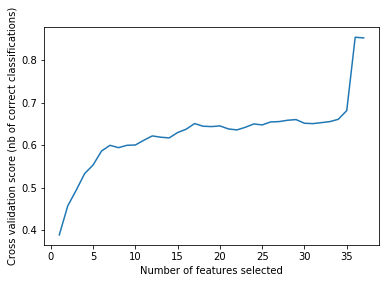

In [13]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear", C=10)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Recursive Feature Elimination (without cross-validation)

From [here](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py)

//Needs the `coef_` or  `feature_importances_` attributes which the rbf kernal does not expose

In [19]:
print(__doc__)

from sklearn.svm import SVC
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt


# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X_train, y_train)
#ranking = rfe.ranking_.reshape(X_train.shape)

# Plot pixel ranking
rfe.ranking_

Automatically created module for IPython interactive environment


array([37, 30, 36, 12, 15, 35, 21, 28, 31, 13,  5,  8, 33, 18, 26, 17, 22,
        9, 27, 34, 24, 29, 19, 10, 16,  3, 25,  2,  4,  1, 11, 20, 32,  7,
       23,  6, 14])